### Diabetes Disease classification Logistic Regression Model

In [158]:
import findspark
findspark.init()

In [159]:
#create a sparksession
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('Diabetes_classification').getOrCreate()

### TASK 2: Reading dataset

In [160]:
#create spark dataframe
df =spark.read.csv("diabetes.csv", header=True, inferSchema=True)

In [161]:
#display the dataframe
df.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          2|    138|           62|           35|      0|33.6|                   0.127| 47|      1|
|          0|     84|           82|           31|    125|38.2|                   0.233| 23|      0|
|          0|    145|            0|            0|      0|44.2|                    0.63| 31|      1|
|          0|    135|           68|           42|    250|42.3|                   0.365| 24|      1|
|          1|    139|           62|           41|    480|40.7|                   0.536| 21|      0|
|          0|    173|           78|           32|    265|46.5|                   1.159| 58|      0|
|          4|     99|           72|           17|      0|25.6|                   0.294| 28|      0|


In [162]:
#print the schema
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



In [163]:
#count the total no. of diabetic and non-diabetic class
print((df.count(),len(df.columns)))
df.groupBy('outcome').count().show()

(2000, 9)
+-------+-----+
|outcome|count|
+-------+-----+
|      1|  684|
|      0| 1316|
+-------+-----+



In [166]:
#get the summary statistics
df.describe().show(vertical=True)

-RECORD 0---------------------------------------
 summary                  | count               
 Pregnancies              | 2000                
 Glucose                  | 2000                
 BloodPressure            | 2000                
 SkinThickness            | 2000                
 Insulin                  | 2000                
 BMI                      | 2000                
 DiabetesPedigreeFunction | 2000                
 Age                      | 2000                
 Outcome                  | 2000                
-RECORD 1---------------------------------------
 summary                  | mean                
 Pregnancies              | 3.7035              
 Glucose                  | 121.1825            
 BloodPressure            | 69.1455             
 SkinThickness            | 20.935              
 Insulin                  | 80.254              
 BMI                      | 32.192999999999984  
 DiabetesPedigreeFunction | 0.47092999999999974 
 Age                

In [167]:
df.describe().toPandas()

summary        Pregnancies             Glucose       BloodPressure  \
0   count               2000                2000                2000   
1    mean             3.7035            121.1825             69.1455   
2  stddev  3.306063032730656  32.068635649902916  19.188314815604098   
3     min                  0                   0                   0   
4     max                 17                 199                 122   

       SkinThickness            Insulin                 BMI  \
0               2000               2000                2000   
1             20.935             80.254  32.192999999999984   
2  16.10324290992682  111.1805335457595   8.149900701279762   
3                  0                  0                 0.0   
4                110                744                80.6   

  DiabetesPedigreeFunction                 Age             Outcome  
0                     2000                2000                2000  
1      0.47092999999999974             33.0905               0.342  
2       0.3235525586811429  11.786423106049496  0.4744982342297426  
3                    0.078                  21                   0  
4                     2.42                  81                   1

# TASK 3: Data Cleaning & Preparation

In [168]:
#check for null values
for col in df.columns:
  print(col+":",df[df[col].isNull()].count())

Pregnancies: 0
Glucose: 0
BloodPressure: 0
SkinThickness: 0
Insulin: 0
BMI: 0
DiabetesPedigreeFunction: 0
Age: 0
Outcome: 0


In [169]:
df.show(100)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          2|    138|           62|           35|      0|33.6|                   0.127| 47|      1|
|          0|     84|           82|           31|    125|38.2|                   0.233| 23|      0|
|          0|    145|            0|            0|      0|44.2|                    0.63| 31|      1|
|          0|    135|           68|           42|    250|42.3|                   0.365| 24|      1|
|          1|    139|           62|           41|    480|40.7|                   0.536| 21|      0|
|          0|    173|           78|           32|    265|46.5|                   1.159| 58|      0|
|          4|     99|           72|           17|      0|25.6|                   0.294| 28|      0|


In [170]:
#look for the unnecessary values present
def count_zeros():
  columns_list = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
  for i in columns_list:
    print(i+ ":",df[df[i]==0].count())

In [171]:
count_zeros()

Glucose: 13
BloodPressure: 90
SkinThickness: 573
Insulin: 956
BMI: 28


In [172]:
df.columns

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

In [173]:
#calculate and replace the unnecessary values by the mean value
from pyspark.sql.functions import *
for i in df.columns[1:6]:
  data = df.agg({i:'mean'}).first()[0]
  print("mean value for {} is {}".format(i,int(data)))
  df = df.withColumn(i,when(df[i]==0,int(data)).otherwise(df[i]))

mean value for Glucose is 121
mean value for BloodPressure is 69
mean value for SkinThickness is 20
mean value for Insulin is 80
mean value for BMI is 32


In [174]:
#display the dataframe 
df.show(200)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          2|    138|           62|           35|     80|33.6|                   0.127| 47|      1|
|          0|     84|           82|           31|    125|38.2|                   0.233| 23|      0|
|          0|    145|           69|           20|     80|44.2|                    0.63| 31|      1|
|          0|    135|           68|           42|    250|42.3|                   0.365| 24|      1|
|          1|    139|           62|           41|    480|40.7|                   0.536| 21|      0|
|          0|    173|           78|           32|    265|46.5|                   1.159| 58|      0|
|          4|     99|           72|           17|     80|25.6|                   0.294| 28|      0|


# TASK 4: Correlation Analysis & Feature Selection

In [175]:
#find the correlation among the set of input & output variables
for i in df.columns:
  print("Correlation to outcome for {} is {}".format(i,df.stat.corr('outcome',i)))


Correlation to outcome for Pregnancies is 0.22443699263363961
Correlation to outcome for Glucose is 0.48796646527321064
Correlation to outcome for BloodPressure is 0.17171333286446713
Correlation to outcome for SkinThickness is 0.1659010662889893
Correlation to outcome for Insulin is 0.1711763270226193
Correlation to outcome for BMI is 0.2827927569760082
Correlation to outcome for DiabetesPedigreeFunction is 0.1554590791569403
Correlation to outcome for Age is 0.23650924717620253
Correlation to outcome for Outcome is 1.0


In [176]:
#feature selection
from pyspark.ml.feature import VectorAssembler
assembler=VectorAssembler(inputCols=['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age'],outputCol='features')
output_data = assembler.transform(df)

In [177]:
#print the schema
output_data.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)
 |-- features: vector (nullable = true)



In [178]:
#display dataframe
output_data.show(truncate=False)


+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+-------------------------------------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI |DiabetesPedigreeFunction|Age|Outcome|features                                   |
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+-------------------------------------------+
|2          |138    |62           |35           |80     |33.6|0.127                   |47 |1      |[2.0,138.0,62.0,35.0,80.0,33.6,0.127,47.0] |
|0          |84     |82           |31           |125    |38.2|0.233                   |23 |0      |[0.0,84.0,82.0,31.0,125.0,38.2,0.233,23.0] |
|0          |145    |69           |20           |80     |44.2|0.63                    |31 |1      |[0.0,145.0,69.0,20.0,80.0,44.2,0.63,31.0]  |
|0          |135    |68           |42           |250    |42.3|0.365                   |24 |1      |[0.0,135.0,68.0,42.0,250.0,42.3,0.365

# TASK 5: Split Dataset & Build the Model

In [179]:
#create final data
from pyspark.ml.classification import LogisticRegression
final_data = output_data.select('features','outcome')

In [180]:
#print schema of final data
final_data.printSchema()

root
 |-- features: vector (nullable = true)
 |-- outcome: integer (nullable = true)



In [181]:
#split the dataset ; build the model
train,test =final_data.randomSplit([0.7,0.3], seed=123)
models =LogisticRegression(labelCol='outcome')
model=models.fit(train)

In [183]:
#summary of the model
summary=model.summary
summary.predictions.show(truncate=False)

+------------------------------------------+-------+----------------------------------------+-----------------------------------------+----------+
|features                                  |outcome|rawPrediction                           |probability                              |prediction|
+------------------------------------------+-------+----------------------------------------+-----------------------------------------+----------+
|[0.0,57.0,60.0,20.0,80.0,21.7,0.735,67.0] |0.0    |[4.067974103164073,-4.067974103164073]  |[0.9831758741840879,0.016824125815912083]|0.0       |
|[0.0,57.0,60.0,20.0,80.0,21.7,0.735,67.0] |0.0    |[4.067974103164073,-4.067974103164073]  |[0.9831758741840879,0.016824125815912083]|0.0       |
|[0.0,67.0,76.0,20.0,80.0,45.3,0.194,46.0] |0.0    |[2.5336586032230644,-2.5336586032230644]|[0.9264679851692322,0.07353201483076777] |0.0       |
|[0.0,73.0,69.0,20.0,80.0,21.1,0.342,25.0] |0.0    |[4.29857857783044,-4.29857857783044]    |[0.9865942954517222,0.013

In [184]:
summary.predictions.toPandas()

features  outcome  \
0      [0.0, 57.0, 60.0, 20.0, 80.0, 21.7, 0.735, 67.0]      0.0   
1      [0.0, 57.0, 60.0, 20.0, 80.0, 21.7, 0.735, 67.0]      0.0   
2      [0.0, 67.0, 76.0, 20.0, 80.0, 45.3, 0.194, 46.0]      0.0   
3      [0.0, 73.0, 69.0, 20.0, 80.0, 21.1, 0.342, 25.0]      0.0   
4      [0.0, 73.0, 69.0, 20.0, 80.0, 21.1, 0.342, 25.0]      0.0   
...                                                 ...      ...   
1381  [14.0, 175.0, 62.0, 30.0, 80.0, 33.6, 0.212, 3...      1.0   
1382  [14.0, 175.0, 62.0, 30.0, 80.0, 33.6, 0.212, 3...      1.0   
1383  [15.0, 136.0, 70.0, 32.0, 110.0, 37.1, 0.153, ...      1.0   
1384  [17.0, 163.0, 72.0, 41.0, 114.0, 40.9, 0.817, ...      1.0   
1385  [17.0, 163.0, 72.0, 41.0, 114.0, 40.9, 0.817, ...      1.0   

                                  rawPrediction  \
0       [4.067974103164073, -4.067974103164073]   
1       [4.067974103164073, -4.067974103164073]   
2     [2.5336586032230644, -2.5336586032230644]   
3         [4.29857857783044, -4.29857857783044]   
4         [4.29857857783044, -4.29857857783044]   
...                                         ...   
1381  [-2.4740928854344997, 2.4740928854344997]   
1382  [-2.4740928854344997, 2.4740928854344997]   
1383  [-1.4326810889465822, 1.4326810889465822]   
1384    [-3.626072962789584, 3.626072962789584]   
1385    [-3.626072962789584, 3.626072962789584]   

                                     probability  prediction  
0     [0.9831758741840879, 0.016824125815912083]         0.0  
1     [0.9831758741840879, 0.016824125815912083]         0.0  
2      [0.9264679851692322, 0.07353201483076777]         0.0  
3      [0.9865942954517222, 0.01340570454827783]         0.0  
4      [0.9865942954517222, 0.01340570454827783]         0.0  
...                                          ...         ...  
1381   [0.07769443968861331, 0.9223055603113867]         1.0  
1382   [0.07769443968861331, 0.9223055603113867]         1.0  
1383   [0.19268128322193723, 0.8073187167780628]         1.0  
1384  [0.025930242658861638, 0.9740697573411383]         1.0  
1385  [0.025930242658861638, 0.9740697573411383]         1.0  

[1386 rows x 5 columns]

### TASK 6: Evaluate the Model

In [185]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
predictions=model.evaluate(test)

In [189]:
predictions.predictions.show()

+--------------------+-------+--------------------+--------------------+----------+
|            features|outcome|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|[0.0,67.0,76.0,20...|      0|[2.53365860322306...|[0.92646798516923...|       0.0|
|[0.0,74.0,52.0,10...|      0|[3.74182647060574...|[0.97683842198008...|       0.0|
|[0.0,78.0,88.0,29...|      0|[2.85467591682677...|[0.94555988418016...|       0.0|
|[0.0,84.0,64.0,22...|      0|[2.57389730080405...|[0.92916264345452...|       0.0|
|[0.0,84.0,64.0,22...|      0|[2.57389730080405...|[0.92916264345452...|       0.0|
|[0.0,86.0,68.0,32...|      0|[2.80490676074123...|[0.94294040098171...|       0.0|
|[0.0,91.0,80.0,20...|      0|[2.48835640878332...|[0.92332151914454...|       0.0|
|[0.0,93.0,60.0,25...|      0|[2.83335800802880...|[0.94445203435006...|       0.0|
|[0.0,93.0,60.0,25...|      0|[2.83335800802880...|[0.94445203435006...|    

In [190]:
evaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='outcome')
evaluator.evaluate(model.transform(test))
## areaUnderROC

0.8367406542056083

In [191]:
predictionAndLabels = model.transform(test)
predictionAndLabels.show(2,False)

+-----------------------------------------+-------+----------------------------------------+-----------------------------------------+----------+
|features                                 |outcome|rawPrediction                           |probability                              |prediction|
+-----------------------------------------+-------+----------------------------------------+-----------------------------------------+----------+
|[0.0,67.0,76.0,20.0,80.0,45.3,0.194,46.0]|0      |[2.5336586032230644,-2.5336586032230644]|[0.9264679851692322,0.07353201483076777] |0.0       |
|[0.0,74.0,52.0,10.0,36.0,27.8,0.269,22.0]|0      |[3.741826470605745,-3.741826470605745]  |[0.9768384219800843,0.023161578019915696]|0.0       |
+-----------------------------------------+-------+----------------------------------------+-----------------------------------------+----------+
only showing top 2 rows



In [192]:
predictionAndLabels.toPandas()

features  outcome  \
0     [0.0, 67.0, 76.0, 20.0, 80.0, 45.3, 0.194, 46.0]        0   
1     [0.0, 74.0, 52.0, 10.0, 36.0, 27.8, 0.269, 22.0]        0   
2     [0.0, 78.0, 88.0, 29.0, 40.0, 36.9, 0.434, 21.0]        0   
3     [0.0, 84.0, 64.0, 22.0, 66.0, 35.8, 0.545, 21.0]        0   
4     [0.0, 84.0, 64.0, 22.0, 66.0, 35.8, 0.545, 21.0]        0   
..                                                 ...      ...   
609  [13.0, 158.0, 114.0, 20.0, 80.0, 42.3, 0.257, ...        1   
610  [14.0, 100.0, 78.0, 25.0, 184.0, 36.6, 0.412, ...        1   
611  [14.0, 100.0, 78.0, 25.0, 184.0, 36.6, 0.412, ...        1   
612  [15.0, 136.0, 70.0, 32.0, 110.0, 37.1, 0.153, ...        1   
613  [17.0, 163.0, 72.0, 41.0, 114.0, 40.9, 0.817, ...        1   

                                   rawPrediction  \
0      [2.5336586032230644, -2.5336586032230644]   
1        [3.741826470605745, -3.741826470605745]   
2        [2.854675916826773, -2.854675916826773]   
3        [2.573897300804054, -2.573897300804054]   
4        [2.573897300804054, -2.573897300804054]   
..                                           ...   
609    [-2.4984071221269915, 2.4984071221269915]   
610  [-0.18916774943137327, 0.18916774943137327]   
611  [-0.18916774943137327, 0.18916774943137327]   
612    [-1.4326810889465822, 1.4326810889465822]   
613      [-3.626072962789584, 3.626072962789584]   

                                    probability  prediction  
0     [0.9264679851692322, 0.07353201483076777]         0.0  
1    [0.9768384219800843, 0.023161578019915696]         0.0  
2     [0.9455598841801626, 0.05444011581983743]         0.0  
3     [0.9291626434545274, 0.07083735654547263]         0.0  
4     [0.9291626434545274, 0.07083735654547263]         0.0  
..                                          ...         ...  
609   [0.07596992215018353, 0.9240300778498165]         1.0  
610        [0.45284858608941, 0.54715141391059]         1.0  
611        [0.45284858608941, 0.54715141391059]         1.0  
612   [0.19268128322193723, 0.8073187167780628]         1.0  
613  [0.025930242658861638, 0.9740697573411383]         1.0  

[614 rows x 5 columns]

In [193]:
from pyspark.ml.evaluation import *

#dt_hyper_eval = BinaryClassificationEvaluator(predictionAndLabels)
dt_hyper_eval2= MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="outcome")
dt_hyper_ACC  = dt_hyper_eval2.evaluate(predictionAndLabels, {dt_hyper_eval2.metricName:"accuracy"})
print("Logistic Regression Performance Measure")
print("Accuracy = %0.2f" % dt_hyper_ACC)


Logistic Regression Performance Measure
Accuracy = 0.76


In [194]:
dt_hyper_eval = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="outcome")
dt_hyper_AUC  = dt_hyper_eval.evaluate(predictionAndLabels)
print("AUC = %.2f" % dt_hyper_AUC)

AUC = 0.84


In [195]:
predictionAndLabels.show()

+--------------------+-------+--------------------+--------------------+----------+
|            features|outcome|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|[0.0,67.0,76.0,20...|      0|[2.53365860322306...|[0.92646798516923...|       0.0|
|[0.0,74.0,52.0,10...|      0|[3.74182647060574...|[0.97683842198008...|       0.0|
|[0.0,78.0,88.0,29...|      0|[2.85467591682677...|[0.94555988418016...|       0.0|
|[0.0,84.0,64.0,22...|      0|[2.57389730080405...|[0.92916264345452...|       0.0|
|[0.0,84.0,64.0,22...|      0|[2.57389730080405...|[0.92916264345452...|       0.0|
|[0.0,86.0,68.0,32...|      0|[2.80490676074123...|[0.94294040098171...|       0.0|
|[0.0,91.0,80.0,20...|      0|[2.48835640878332...|[0.92332151914454...|       0.0|
|[0.0,93.0,60.0,25...|      0|[2.83335800802880...|[0.94445203435006...|       0.0|
|[0.0,93.0,60.0,25...|      0|[2.83335800802880...|[0.94445203435006...|    

In [196]:
#from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

#preds_and_labels = predictionAndLabels.select(['predictions','d']).withColumn('label', F.col('d').cast(FloatType())).orderBy('prediction')
#important: need to cast to float type, and order by prediction, else it won't work

#select only prediction and label columns
preds_and_labels = predictionAndLabels.select(['prediction','outcome']).withColumn('outcome', col('outcome').cast(FloatType())).orderBy('prediction')
preds_and_labels.show(600) 
#metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
#print(metrics.confusionMatrix().toArray())

+----------+-------+
|prediction|outcome|
+----------+-------+
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    1.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    1.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    1.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    0.0|
|       0.0|    1.0|
|       0.0|    0.0|
|       0.0| 

In [197]:
#confusion matrix
cm_dt_result = predictionAndLabels.crosstab("prediction", "outcome")
cm_dt_result.show()
cm_dt_result = cm_dt_result.toPandas()
cm_dt_result.head()
#cm_dt_result.sort_values(by = ['prediction_outcome'])

+------------------+---+---+
|prediction_outcome|  0|  1|
+------------------+---+---+
|               1.0| 50|117|
|               0.0|350| 97|
+------------------+---+---+



prediction_outcome    0    1
0                1.0   50  117
1                0.0  350   97

TP=
FP=
FN=
TN=

In [147]:
cm_dt_result.index

RangeIndex(start=0, stop=2, step=1)

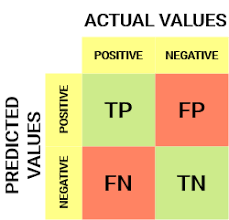

In [148]:
type(cm_dt_result)

pandas.core.frame.DataFrame

In [198]:
#calculate accuracy, sensitivity, specificity and precision
TP = cm_dt_result["1"][0]
FP = cm_dt_result["0"][0]
TN = cm_dt_result["0"][1]
FN = cm_dt_result["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

Accuracy = 0.76
Sensitivity = 0.55
Specificity = 0.88
Precision = 0.70


In [199]:
from sklearn.metrics import classification_report
preds_and_labels_pdf = preds_and_labels.toPandas()
print(classification_report(preds_and_labels_pdf['outcome'], preds_and_labels_pdf['prediction']))

              precision    recall  f1-score   support

         0.0       0.78      0.88      0.83       400
         1.0       0.70      0.55      0.61       214

    accuracy                           0.76       614
   macro avg       0.74      0.71      0.72       614
weighted avg       0.75      0.76      0.75       614



# TASK 7: Prediction on New Data 

In [200]:
#create a new spark dataframe
test_df = spark.read.csv("new_test.csv",header=True,inferSchema=True)
test_df.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+
|          1|    190|           78|           38|    150|45.1|                   0.153| 48|
|          0|     80|           84|           36|    120|50.2|                   0.211| 26|
|          2|    138|           82|           46|    255|52.3|                   0.315| 30|
|          1|    110|           63|           44|    480|62.7|                   0.616| 32|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+



In [201]:
#print the schema
test_df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)



In [202]:
#create an additional feature merged column 
test_data=assembler.transform(test_df)

In [203]:
#print the schema
test_data.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- features: vector (nullable = true)



In [204]:
#use model to make predictions
results=model.transform(test_data)
results.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [205]:
#display the predictions
results.select('features','prediction').show(truncate=False)

+-------------------------------------------+----------+
|features                                   |prediction|
+-------------------------------------------+----------+
|[1.0,190.0,78.0,38.0,150.0,45.1,0.153,48.0]|1.0       |
|[0.0,80.0,84.0,36.0,120.0,50.2,0.211,26.0] |0.0       |
|[2.0,138.0,82.0,46.0,255.0,52.3,0.315,30.0]|1.0       |
|[1.0,110.0,63.0,44.0,480.0,62.7,0.616,32.0]|1.0       |
+-------------------------------------------+----------+

